In [2]:
import os
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

IMG_DIM = 256

In [10]:
def bensYCC(bgr, weight=4, gamma=15):
# def bensYCC(bgr, weight=4, gamma=26): for 360?
        
    # convert to y, cr, cb so that we can modify the image based on just the y (brightness)
    ycc = cv2.cvtColor(bgr, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycc)

    # perform bens algorithm on the y component
    y = cv2.addWeighted(y, weight, cv2.GaussianBlur(y, (0,0), gamma), -weight, 128)

    # merge the ycc back together, and recolor it
    ycc_modified = cv2.merge((y, cr, cb))
    bens = cv2.cvtColor(ycc_modified, cv2.COLOR_YCrCb2BGR)
    
    return bens 


# def bensWeird(gray, weight=4, gamma=26):
        
#     bens = cv2.addWeighted(gray, weight, cv2.GaussianBlur(gray, (0,0), gamma), -weight, 128)
    
#     return bens 

In [4]:
def crop(gray, img, percent_smaller):
    
    thresh = 8
    
    top    = 0
    left   = 0
    bottom = gray.shape[0] - 1
    right  = gray.shape[1] - 1
    
    # work in from the top and bottom along the middle collumn
    middleCol = gray[:, int(gray.shape[1]/2)] > thresh
    while middleCol[top] == 0:
        top += 1
    while middleCol[bottom] == 0:
        bottom -= 1
        
    # work in from the sides along the middle row
    middleRow = gray[int(gray.shape[0]/2)] > thresh
    while middleRow[left] == 0:
        left += 1
    while middleRow[right] == 0:
        right -= 1
        
    height = bottom - top
    width  = right - left
    
    bottom -= int(percent_smaller*height)
    top    += int(percent_smaller*height)
    right  -= int(percent_smaller*width)
    left   += int(percent_smaller*width)
        
    if height < 100 or width < 100:
        print("Error: squareUp: bottom:", bottom, "top:", top)
        print("Error: squareUp: right:", right, "left:", left)
        return img
    
    return img[top:bottom, left:right]

    

In [5]:
def reflectAndSquareUp(img):
    
    height = img.shape[0]
    width  = img.shape[1]
    
    # if its portrait mode, it's probably already kind of square. Make it properly square by cutting
    # down the height until the dimensions match
    if (height > width):
        
        offset = int((height - width)/2)
        return img[offset:offset+width]
    
    # otherwise, do the whole reflection thingo
    else:
        if len(img.shape) == 3:
            new_img = np.zeros((width, width, img.shape[2]), np.uint8)
        else:
            new_img = np.zeros((width, width), np.uint8)

        #  0  |
        #     |
        #  h1 |####
        #     |####
        #     |####
        #  h2 |
        #     |

        h1 = int((width - height)/2)
        h2 = h1 + height

        # paste the original into the center
        new_img[h1:h2,:] = img

        # paste in the reflections
        for i in range(h1):
            new_img[h1-i] = img[i]

        for i in range(width - h2):
            new_img[h2+i] = img[height - i - 1]

        return new_img

def circleMask(img):
    
    if (img.shape[0] != img.shape[1]):
        print("Error: circle mask assumes square image")
        return img
    
    dim = img.shape[0]
    half = int(dim/2)
    
    # crop out circle:
    circle_mask = np.zeros((dim, dim), np.uint8)
    circle_mask = cv2.circle(circle_mask, (half, half), half, 1, thickness=-1)

    return cv2.bitwise_and(img, img, mask=circle_mask)

def clahe_gray(gray, clipLimit=3.5, grid=8):

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=(grid,grid))
    return clahe.apply(gray)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                     for i in np.arange(0, 256)]).astype("uint8")

    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


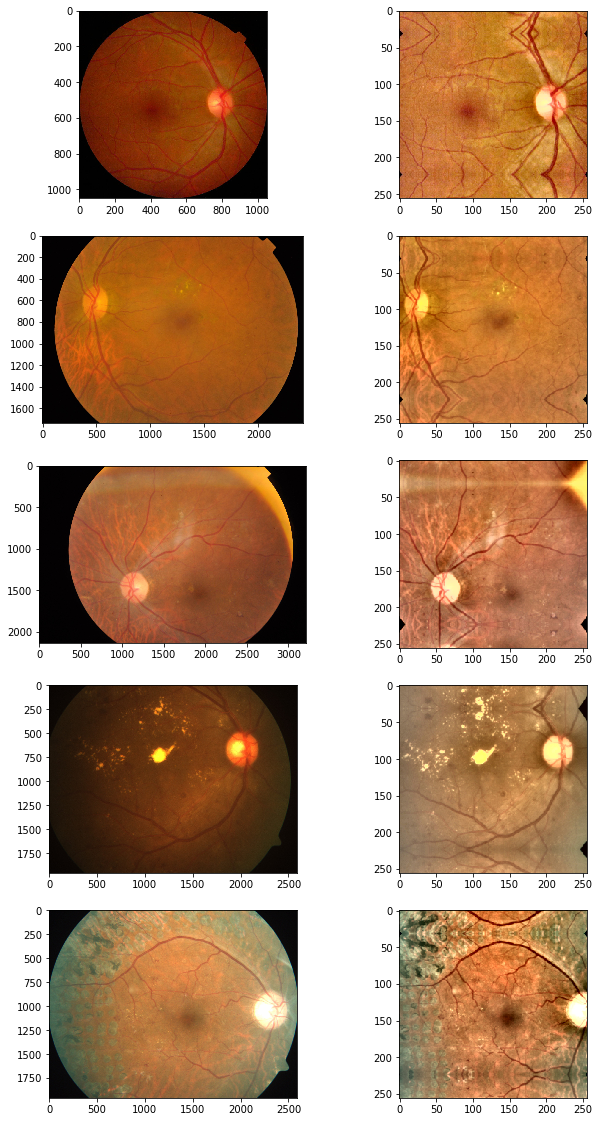

In [9]:
# # Test different versions of colourful eyes

# # the main dataframes
df_2019 = pd.read_csv("../aptos2019/train.csv") 
df_2019.id_code = df_2019.id_code.apply(lambda x: x + ".png")

# df_2015 = pd.read_csv(f"../aptos2015/trainLabels.csv") 
# df_2015.image   = df_2015.image.apply(lambda   x: x + ".jpeg")

# Display some random images from Data Set with class categories.
figure=plt.figure(figsize=(22,20))
for target_class in range(5):
    for id_code in df_2019[df_2019.diagnosis == target_class].id_code.sample(1):
        
        # open the file
        image_file = "../aptos2019/train_images/" + id_code
        bgr   = cv2.imread(image_file)
        green = bgr[:,:,1]
        
        # ---- Original ----
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        ax = figure.add_subplot(5,4, 4*target_class+1)
        plt.imshow(rgb)

        # ========= Crop into test format ========
        cropped = crop(green, bgr, 0.02)
        width  = int(cropped.shape[1] * 0.85)
        height = int(width * 480 / 640)
        if height > cropped.shape[0]:
            height = cropped.shape[0] - 2
        h = int((cropped.shape[0] - height) / 2)
        w = int((cropped.shape[1] - width) / 2)

        test_crop = cropped[h:height+h,w:width+w,:]
#         ax = figure.add_subplot(5,4, 4*target_class+2)
#         plt.imshow(cv2.cvtColor(test_crop, cv2.COLOR_BGR2RGB))

        reflected = reflectAndSquareUp(test_crop)
        resized = cv2.resize(reflected, (IMG_DIM, IMG_DIM), interpolation=cv2.INTER_AREA)
        equalised = adjust_gamma(resized, 1+np.log(90)-np.log(np.median(resized)))

        # ----- Bens normal -----
        normal = bensYCC(equalised, weight=3, gamma=20)
        ax = figure.add_subplot(5,4, 4*target_class+2)
        plt.imshow(cv2.cvtColor(normal, cv2.COLOR_BGR2RGB))
        
        
        # ----- Bens weird -----
#         weird = cv2.resize(bensWeird(equalised), (IMG_DIM, IMG_DIM))
#         ax = figure.add_subplot(5,4, 4*target_class+3)
#         plt.imshow(cv2.cvtColor(weird, cv2.COLOR_BGR2RGB))

#         #  ========= GREENS =========
#         cropped = crop(green, green, 0.02)
#         squared = reflectAndSquareUp(cropped)
#         resized = cv2.resize(squared, (2*IMG_DIM, 2*IMG_DIM))
#         circled = circleMask(resized)
#         equalised = adjust_gamma(circled, 1+np.log(190)-np.log(np.median(circled)))

#         # ----- Clahe Green -----
#         clahe = cv2.resize(clahe_gray(equalised, clipLimit=5, grid=20), (IMG_DIM, IMG_DIM))
#         ax = figure.add_subplot(5,4, 4*target_class+4)
#         plt.imshow(clahe, cmap='gray')

plt.show()

In [13]:
def process_images(year, test=True):
    
    # set the year
    if year == "2019":
        directory = "../aptos2019/train_images/" 
        file_end  = ".png"
        df        = pd.read_csv("../aptos2019/train.csv") 
    elif year == "2015":
        directory = "../aptos2015/train_images/" 
        file_end  = ".jpeg"
        df        = pd.read_csv("../aptos2015/trainLabels.csv") 
        df["id_code"] = df.image
        
    df.id_code = df.id_code.apply(lambda x: x + file_end)
    
    # go through all zeh images und changen them
    if test:
        figure=plt.figure(figsize=(22,20))
    for count, file_name in enumerate(df.id_code.values):

        if count % 1000 == 0:
            print(count)
            
        bens_colour_file = directory + str(IMG_DIM) + "_ben_normal_" + file_name
        
        # ---- do preprocessing common to all ----
        try:
            bgr = cv2.imread(directory + file_name)
            green = bgr[:,:,1]
            
            if test:
                rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
                ax = figure.add_subplot(5,4, 4*count+1)
                plt.imshow(rgb)
            
            # ========= COLOURED ========
            cropped = crop(green, bgr, 0.02)
            width  = int(cropped.shape[1] * 0.86)
            height = int(width * 480 / 640)
            if height > cropped.shape[0]:
                height = cropped.shape[0] - 2
            h = int((cropped.shape[0] - height) / 2)
            w = int((cropped.shape[1] - width) / 2)

            test_crop = cropped[h:height+h,w:width+w,:]

#             reflected = reflectAndSquareUp(test_crop)
            resized = cv2.resize(test_crop, (IMG_DIM, IMG_DIM), interpolation=cv2.INTER_AREA)
#             equalised = adjust_gamma(resized, 1+np.log(90)-np.log(np.median(resized)))

            # ----- Bens normal -----
            if test or not os.path.isfile(bens_colour_file):
                new_img = bensYCC(resized)
                if test:
                    rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
                    ax = figure.add_subplot(5,4, 4*count+2)
                    plt.imshow(rgb)
                else:
                    cv2.imwrite(bens_colour_file, new_img)
            
        
            # ----- Bens weird -----
#             if test or not os.path.isfile(bens_green_file):
#                 new_img = cv2.resize(bensWeird(equalised), (IMG_DIM, IMG_DIM))
#                 if test:
#                     rgb = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
#                     ax = figure.add_subplot(5,4, 4*count+3)
#                     plt.imshow(rgb)
#                 else:
#                     cv2.imwrite(bens_green_file, new_img)

#             #  ========= GREENS =========
#             cropped = crop(green, green, 0.02)
#             squared = reflectAndSquareUp(cropped)
#             resized = cv2.resize(squared, (2*IMG_DIM, 2*IMG_DIM))
#             circled = circleMask(resized)
            
#             # ----- Clahe Green -----
#             if test or not os.path.isfile(clahe_green_file):
#                 cla_eq = adjust_gamma(circled, 1+np.log(190)-np.log(np.median(circled)))
#                 new_img = cv2.resize(clahe_gray(cla_eq, clipLimit=5, grid=20), (IMG_DIM, IMG_DIM))
#                 if test:
#                     ax = figure.add_subplot(5,4, 4*count+4)
#                     plt.imshow(new_img, cmap='gray')
#                 else:
#                     cv2.imwrite(clahe_green_file, new_img)
        except:
            print("Error: " + file_name + " failed")
            
        if test and count == 4:
            plt.show()
            break

process_images("2019", False)

0
1000
2000
3000
